# Swish-based classifier using cosine-annealed LR with restarts and data augmentation
- Swish activation, 4 layers, 100 neurons per layer
- LR using cosine-annealing with restarts and cycle multiplicity of 2
- Data is augmentaed via phi rotations, and transvers and longitudinal flips
- Validation score use ensemble of 10 models weighted by loss

### Import modules

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
from __future__ import division
import sys
import os
sys.path.append('../')
from modules.basics import *
from modules.class_basics import *

/home/giles/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Options

In [2]:
with open(DATA_PATH/'feats.pkl', 'rb') as fin:
    train_feats = pickle.load(fin)

In [3]:
n_models = 10
patience = 2
max_epochs = 200

ensemble_size = 10
ensemble_mode = 'loss'

compile_args = {'loss':'binary_crossentropy', 'optimizer':'adam'}
train_params = {'epochs' : 1, 'batch_size' : 256, 'verbose' : 0}
model_params = {'version':'modelSwish', 'n_in':len(train_feats), 'compile_args':compile_args, 'mode':'classifier'}

print ("\nTraining on", len(train_feats), "features:", [var for var in train_feats])


Training on 30 features: ['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_met_pt', 'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_all_pt', 'PRI_tau_px', 'PRI_tau_py', 'PRI_tau_pz', 'PRI_lep_px', 'PRI_lep_pz', 'PRI_jet_leading_px', 'PRI_jet_leading_py', 'PRI_jet_leading_pz', 'PRI_jet_subleading_px', 'PRI_jet_subleading_py', 'PRI_jet_subleading_pz', 'PRI_met_px', 'PRI_met_py']


## Import data

In [4]:
with open(DATA_PATH/'input_pipe.pkl', 'rb') as fin:
    input_pipe = pickle.load(fin)

In [5]:
train_fy = HEPAugFoldYielder(train_feats, h5py.File(DATA_PATH/'train.hdf5', "r+"), rotate=False,
                             input_pipe=None, rot_mult=8)

Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 4


/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


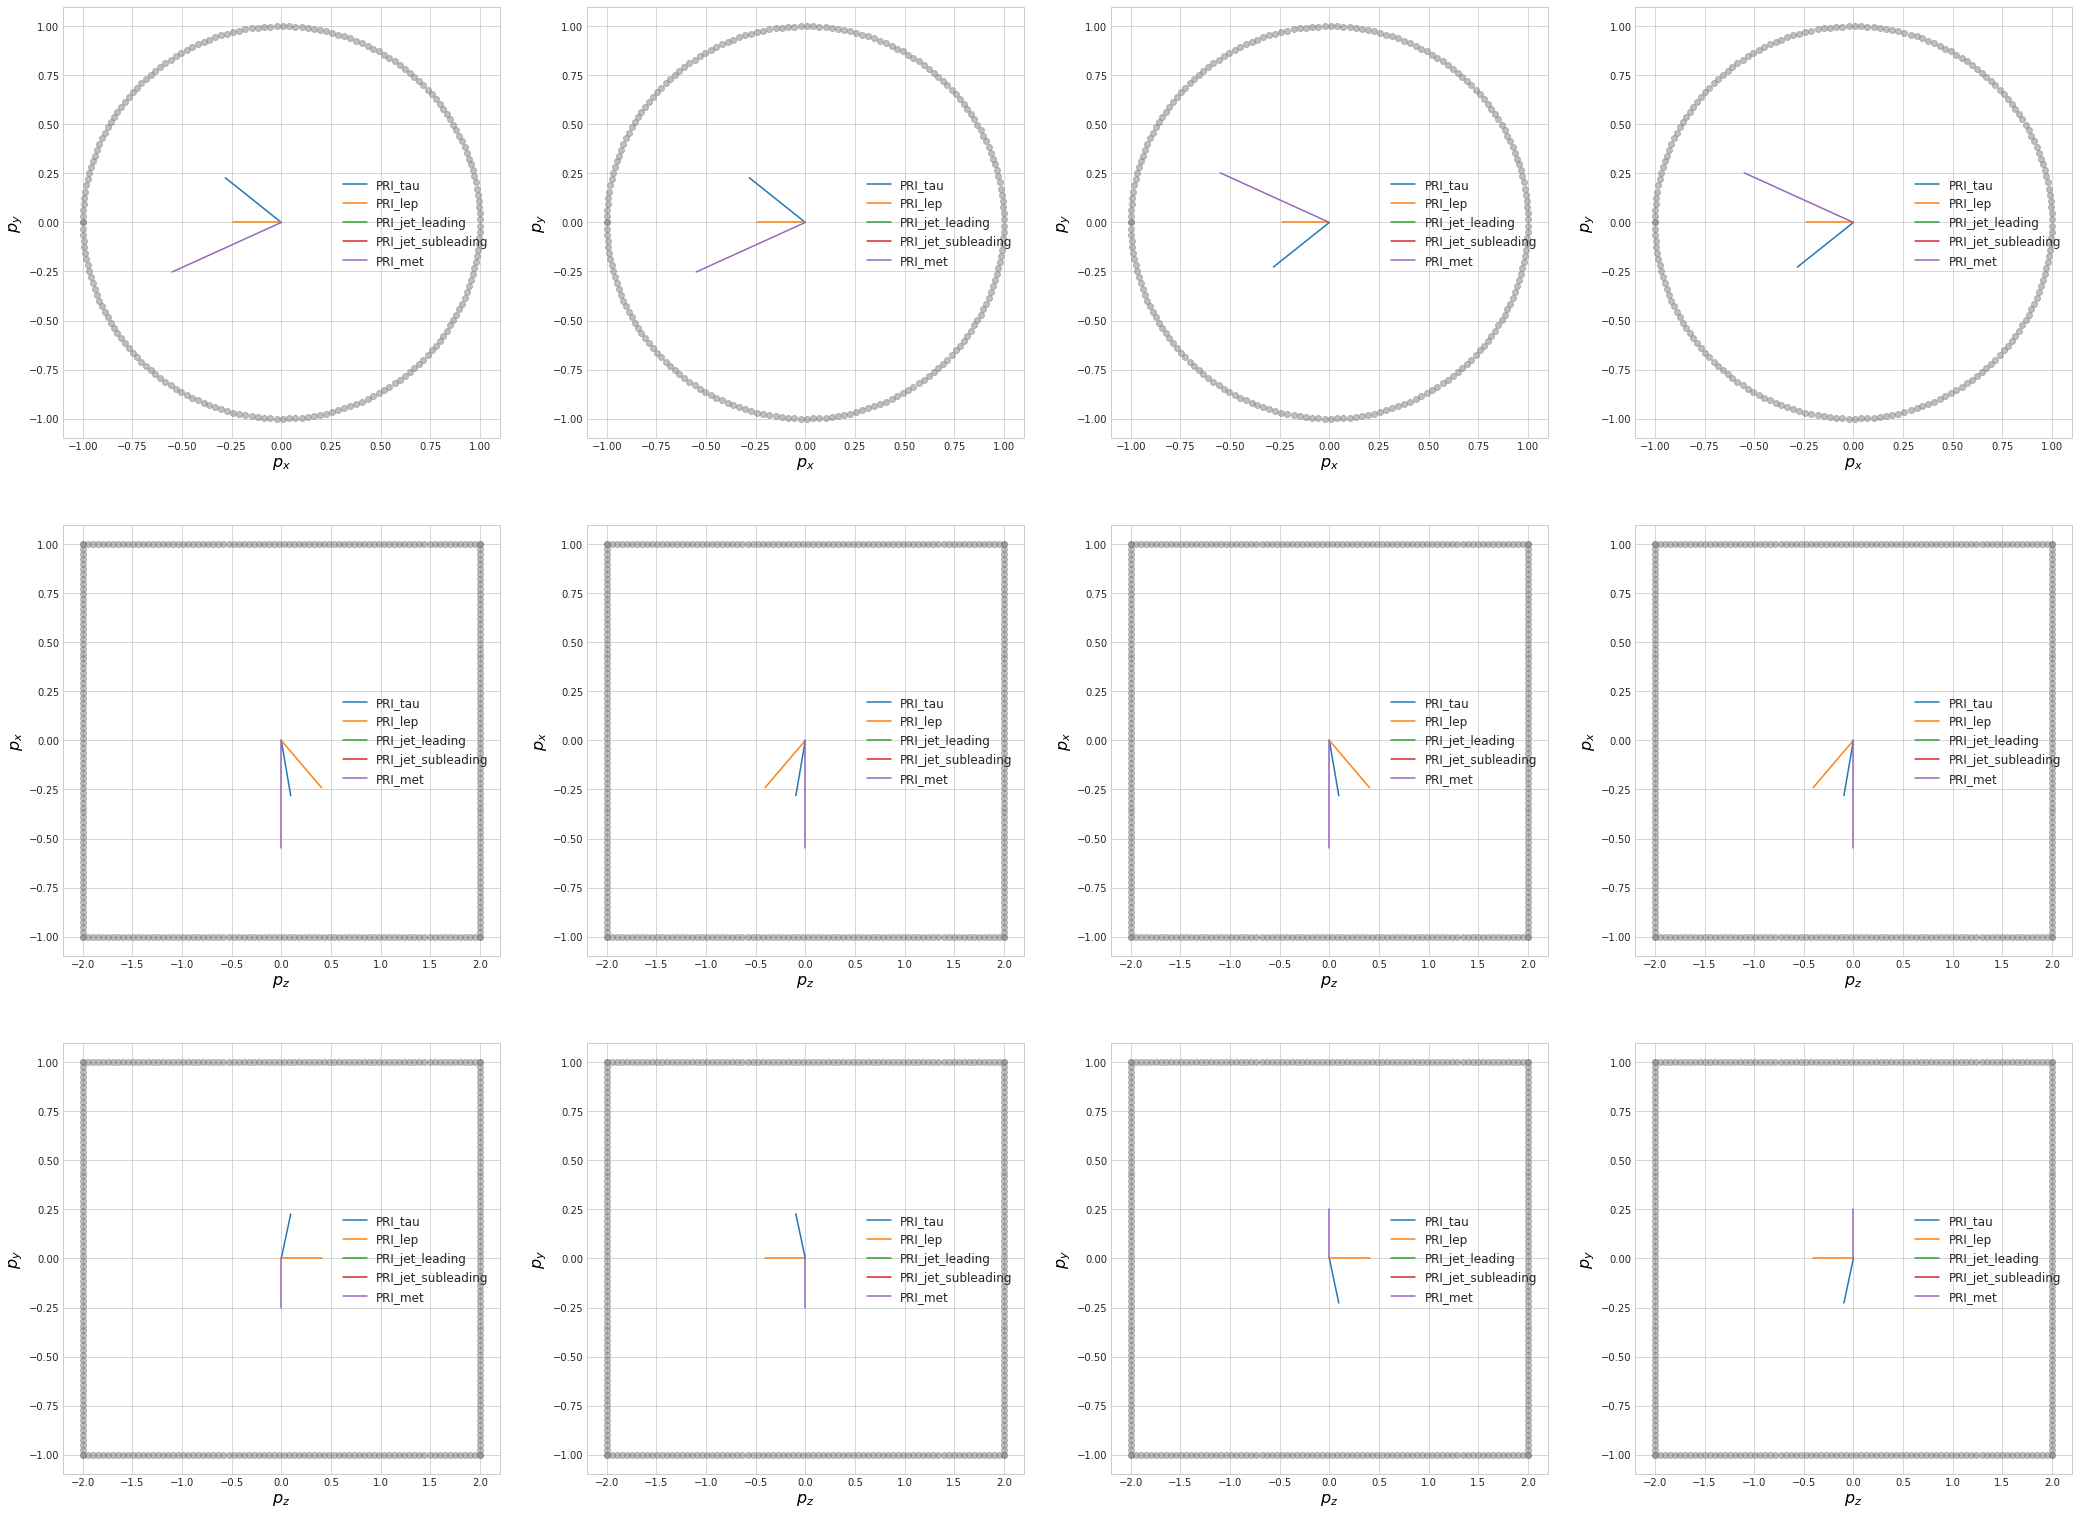

In [6]:
id=3
aug_ranges = [range(4)]
for aug_range in aug_ranges:
    comp_events([pd.DataFrame(train_fy.get_test_fold(0, i)['inputs'], columns=train_feats)[id:id+1] for i in aug_range])

## Determine LR

2 classes found, running in binary mode


______________________________________
Training finished
Cross-validation took 16.967s 


/home/giles/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)
No handles with labels found to put in legend.


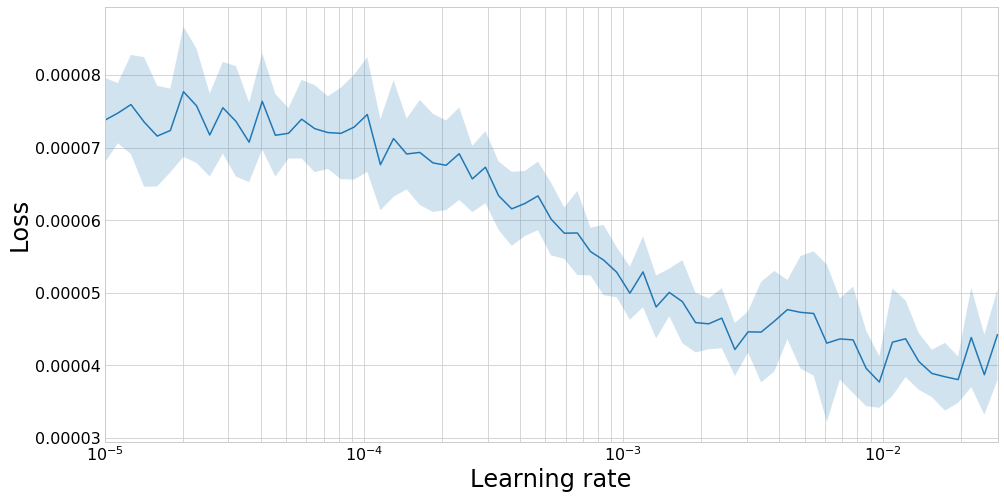

______________________________________



In [7]:
lr_finder = fold_lr_find(train_fy, get_model, model_params, train_params,
                         lr_bounds=[1e-5,1e-1], train_on_weights=True, verbose=0)

## Train classifier

In [8]:
model_gen_params = {**model_params, 'compile_args':{**compile_args, 'lr':2e-3}}
use_callbacks = {'CosAnnealLR':{'cycle_mult':2, 'reverse':False, 'redux_decay':True}}
ams_args = {'n_total':250000, 'br':10, 'delta_b':0}
plots = ['history', 'lr']

Training using weights
Training model 1 / 10
Using cosine LR annealing
2 classes found, running in binary mode

1 New best found: 3.7040830045589246e-05
2 New best found: 3.491842055809684e-05
3 New best found: 3.4261259314371275e-05
4 New best found: 3.3734870473563204e-05
6 New best found: 3.322158776136348e-05
7 New best found: 3.30583206974552e-05
9 New best found: 3.298970200121403e-05
10 New best found: 3.272614632587647e-05
11 New best found: 3.2605387565854474e-05
12 New best found: 3.2433441196917555e-05
13 New best found: 3.2221703251707365e-05
14 New best found: 3.2027053787896876e-05
24 New best found: 3.196764820168028e-05
26 New best found: 3.181058774207486e-05
28 New best found: 3.1727810855954886e-05
29 New best found: 3.1669492612127215e-05
30 New best found: 3.165662277460797e-05
31 New best found: 3.165322769200429e-05
52 New best found: 3.1538363789150024e-05
55 New best found: 3.151737141597551e-05
57 New best found: 3.143755498022074e-05
58 New best found: 3.1368

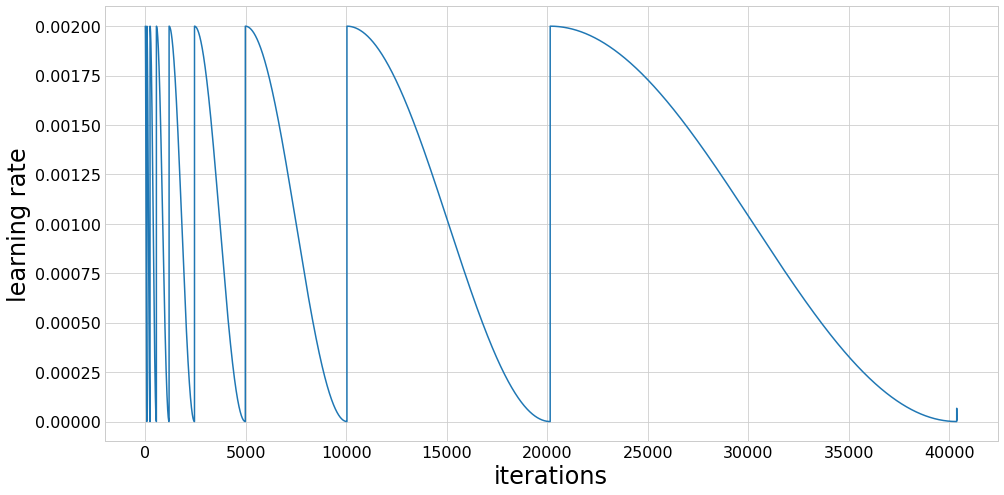

Fold took 441.853s

Training model 2 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.105402). Check your callbacks.
  % delta_t_median)


1 New best found: 3.765251547386372e-05
2 New best found: 3.593106605325938e-05
3 New best found: 3.559215934215237e-05
5 New best found: 3.4551276006264896e-05
6 New best found: 3.421608257934408e-05
7 New best found: 3.4098005492320355e-05
10 New best found: 3.3939704747900284e-05
11 New best found: 3.3613635124796544e-05
12 New best found: 3.347420157705821e-05
13 New best found: 3.342553385724116e-05
14 New best found: 3.319041818825684e-05
15 New best found: 3.3114201728305706e-05
24 New best found: 3.285318153353299e-05
26 New best found: 3.280092636641446e-05
28 New best found: 3.277351713064346e-05
29 New best found: 3.267753517702177e-05
50 New best found: 3.26203559805755e-05
52 New best found: 3.249707616246766e-05
55 New best found: 3.24899660394952e-05
56 New best found: 3.2308962206281066e-05
105 New best found: 3.2271764850734244e-05
108 New best found: 3.223639863377391e-05
110 New best found: 3.219610121921776e-05
113 New best found: 3.218639571143016e-05
114 New best 

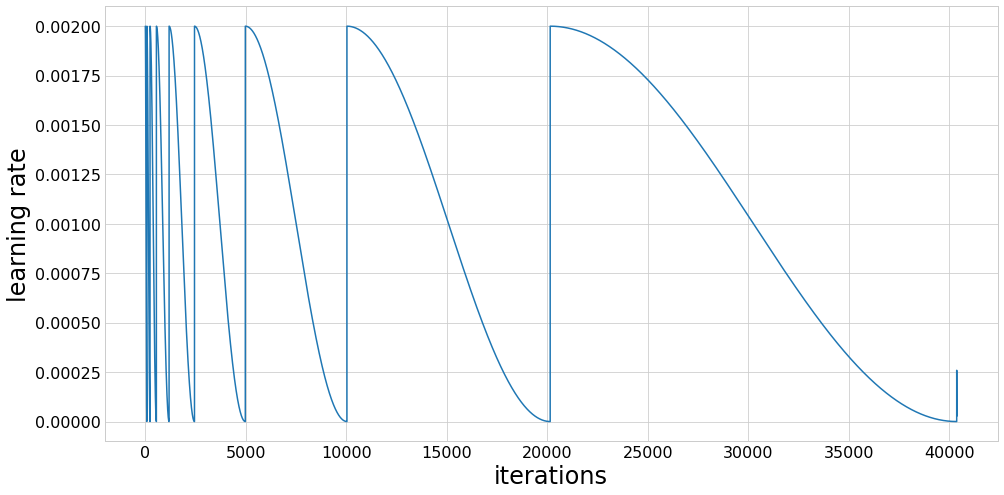

Fold took 450.607s

Training model 3 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.228034). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.114384). Check your callbacks.
  % delta_t_median)


1 New best found: 3.733516725394472e-05
2 New best found: 3.546066711897647e-05
3 New best found: 3.4819457143294044e-05
4 New best found: 3.4644602563123145e-05
5 New best found: 3.341190934957758e-05
6 New best found: 3.308051886873959e-05
7 New best found: 3.303869092556674e-05
11 New best found: 3.27723773208193e-05
13 New best found: 3.240587310709591e-05
14 New best found: 3.235534863697253e-05
15 New best found: 3.231404186113801e-05
22 New best found: 3.222934884507545e-05
23 New best found: 3.214272370503467e-05
25 New best found: 3.2034937668392494e-05
26 New best found: 3.200284002747448e-05
27 New best found: 3.1888585418780107e-05
29 New best found: 3.187043452501973e-05
30 New best found: 3.184058199812434e-05
31 New best found: 3.183886714756936e-05
48 New best found: 3.181107199654651e-05
50 New best found: 3.1793744308399364e-05
52 New best found: 3.174026959006901e-05
54 New best found: 3.163053939725341e-05
56 New best found: 3.162565401151725e-05
57 New best found: 

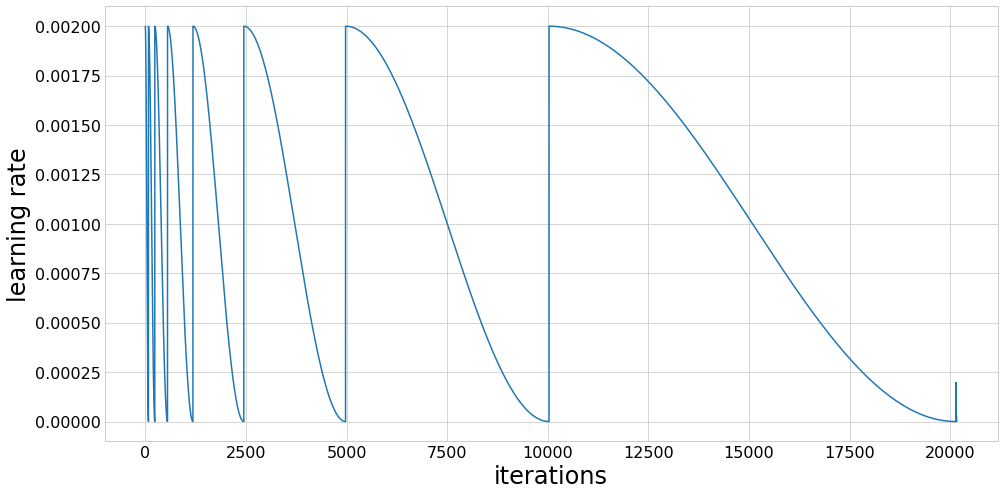

Fold took 246.762s

Training model 4 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.257577). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.129182). Check your callbacks.
  % delta_t_median)


1 New best found: 3.714766887869141e-05
2 New best found: 3.5711575628949967e-05
3 New best found: 3.459269209884945e-05
5 New best found: 3.3780705769040085e-05
6 New best found: 3.3150246286425295e-05
7 New best found: 3.2971283742420266e-05
11 New best found: 3.275448884257204e-05
13 New best found: 3.2691421731138776e-05
14 New best found: 3.246928550765739e-05
15 New best found: 3.2468647973018254e-05
23 New best found: 3.2399588246972264e-05
24 New best found: 3.229847888019723e-05
25 New best found: 3.220031960608253e-05
26 New best found: 3.216155863709395e-05
27 New best found: 3.205528954520499e-05
28 New best found: 3.1989052183545816e-05
29 New best found: 3.195239580166887e-05
30 New best found: 3.193577012882991e-05
31 New best found: 3.193281515903322e-05
51 New best found: 3.1858849906617244e-05
52 New best found: 3.181867723704284e-05
55 New best found: 3.173991976231461e-05
56 New best found: 3.173289162938679e-05
57 New best found: 3.1718289502174265e-05
60 New best 

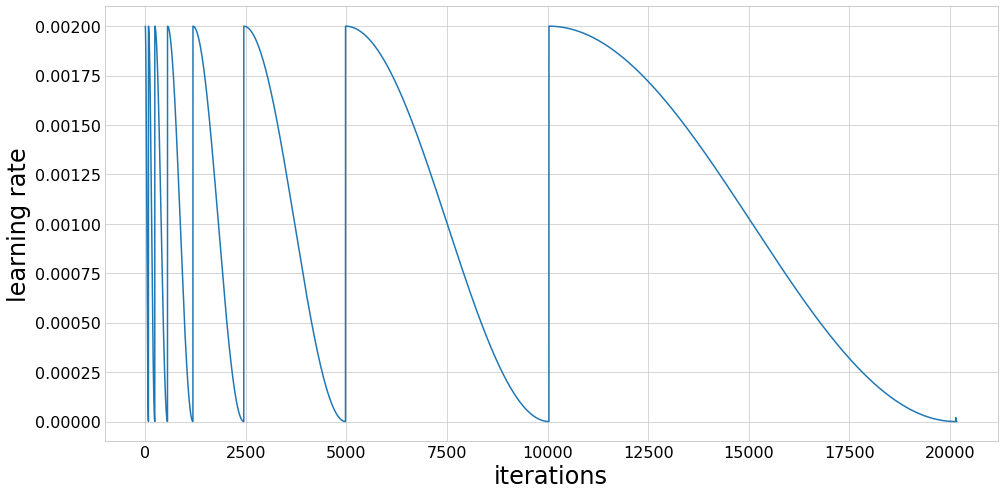

Fold took 255.635s

Training model 5 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.284232). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.142516). Check your callbacks.
  % delta_t_median)


1 New best found: 3.8135919434716926e-05
2 New best found: 3.52915243289317e-05
3 New best found: 3.4554303764889485e-05
4 New best found: 3.417244992160704e-05
5 New best found: 3.389316057873657e-05
6 New best found: 3.3531475634663363e-05
7 New best found: 3.3412117658008354e-05
11 New best found: 3.3187129528960216e-05
12 New best found: 3.303050318500027e-05
13 New best found: 3.288756163965445e-05
14 New best found: 3.278594998482731e-05
15 New best found: 3.27735873463098e-05
25 New best found: 3.267030396600603e-05
26 New best found: 3.2593018693296475e-05
28 New best found: 3.25462164968485e-05
29 New best found: 3.2480655272956936e-05
30 New best found: 3.245737291144905e-05
31 New best found: 3.245162629755214e-05
51 New best found: 3.242922614081181e-05
55 New best found: 3.238445790411788e-05
56 New best found: 3.232441246291273e-05
57 New best found: 3.229265560366912e-05
58 New best found: 3.227873115756665e-05
61 New best found: 3.226545531724696e-05
62 New best found: 

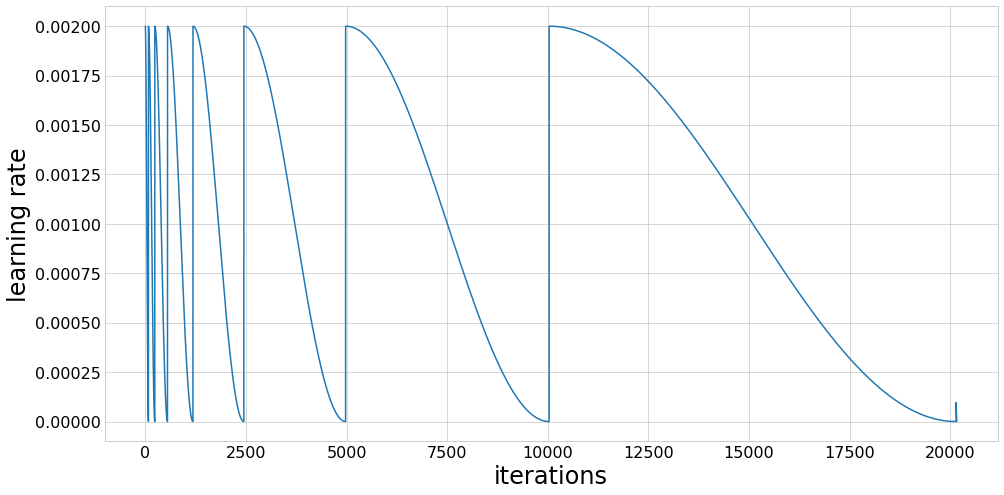

Fold took 257.459s

Training model 6 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.332477). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.166661). Check your callbacks.
  % delta_t_median)


1 New best found: 3.7997022636409385e-05
2 New best found: 3.662665467127226e-05
3 New best found: 3.4954243183892685e-05
5 New best found: 3.4281554815242996e-05
6 New best found: 3.38611387371202e-05
7 New best found: 3.360735604219371e-05
10 New best found: 3.329936717782402e-05
12 New best found: 3.312626949191326e-05
13 New best found: 3.3045360395044556e-05
14 New best found: 3.2923338763066565e-05
21 New best found: 3.285240540135419e-05
22 New best found: 3.280703440977959e-05
24 New best found: 3.273028771509416e-05
25 New best found: 3.2637706084642556e-05
27 New best found: 3.249837704352103e-05
28 New best found: 3.241670992865693e-05
30 New best found: 3.2361980830319223e-05
31 New best found: 3.235867145995144e-05
48 New best found: 3.228815616312204e-05
52 New best found: 3.223134346189909e-05
54 New best found: 3.216813418548554e-05
57 New best found: 3.2022474067343865e-05
110 New best found: 3.2001281369593925e-05
111 New best found: 3.1919100441155024e-05
CosineAnnea

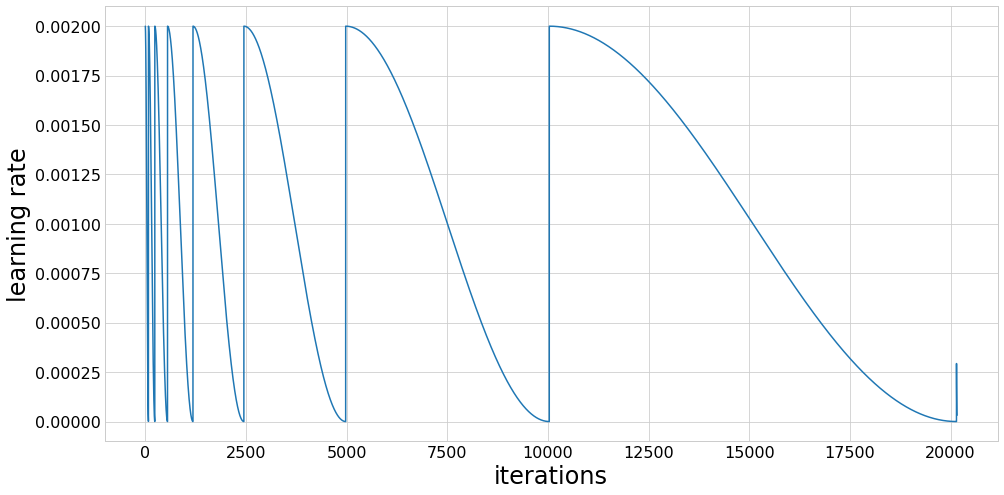

Fold took 255.589s

Training model 7 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.323723). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.162239). Check your callbacks.
  % delta_t_median)


1 New best found: 3.753211438369454e-05
2 New best found: 3.521793141985189e-05
3 New best found: 3.462099188733895e-05
4 New best found: 3.406946483452259e-05
5 New best found: 3.33116145778118e-05
6 New best found: 3.287582833947763e-05
7 New best found: 3.275558304358442e-05
10 New best found: 3.263391519332277e-05
11 New best found: 3.258040801572629e-05
12 New best found: 3.219536684672637e-05
13 New best found: 3.196188841329985e-05
14 New best found: 3.189933208857157e-05
15 New best found: 3.188477512424023e-05
23 New best found: 3.1854462532387476e-05
24 New best found: 3.179726882707169e-05
26 New best found: 3.151068917820109e-05
28 New best found: 3.150104692805896e-05
29 New best found: 3.146646643108507e-05
48 New best found: 3.140999294091821e-05
49 New best found: 3.140567518844146e-05
51 New best found: 3.1356996585106684e-05
53 New best found: 3.132894112588684e-05
54 New best found: 3.126285920790376e-05
55 New best found: 3.1218423227706365e-05
56 New best found: 3.

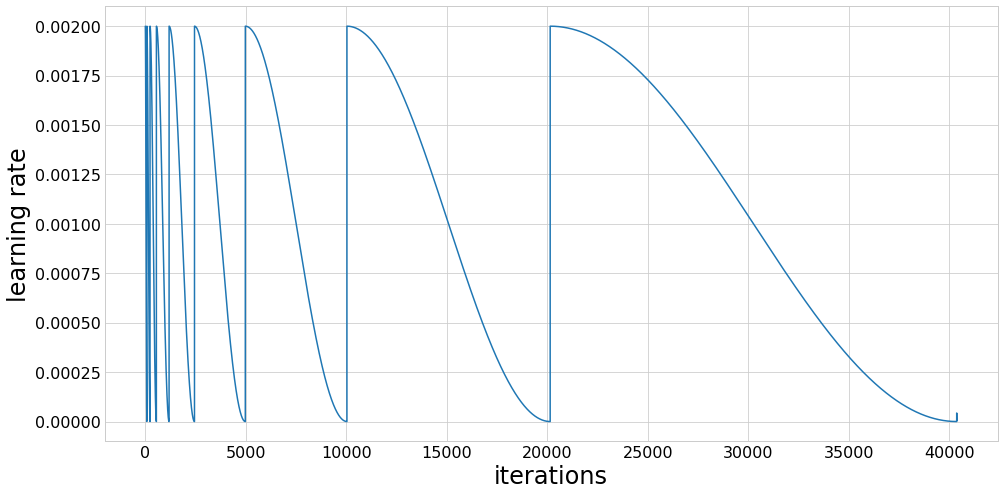

Fold took 507.818s

Training model 8 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.350519). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.175622). Check your callbacks.
  % delta_t_median)


1 New best found: 3.814719295623945e-05
2 New best found: 3.602500046690693e-05
3 New best found: 3.51927649389836e-05
4 New best found: 3.4869345196784705e-05
5 New best found: 3.4058916186040735e-05
6 New best found: 3.3596285169187467e-05
7 New best found: 3.338095542130759e-05
11 New best found: 3.317901685950346e-05
12 New best found: 3.2916088328056506e-05
13 New best found: 3.2635389923962064e-05
14 New best found: 3.2554327935213226e-05
15 New best found: 3.251809640423744e-05
22 New best found: 3.2420119090238584e-05
23 New best found: 3.232258226635167e-05
26 New best found: 3.2145385754847666e-05
27 New best found: 3.208982419964741e-05
28 New best found: 3.20540797940339e-05
29 New best found: 3.205201982345898e-05
30 New best found: 3.20407370076282e-05
31 New best found: 3.2033361163485095e-05
48 New best found: 3.199431171960896e-05
49 New best found: 3.185710900725098e-05
53 New best found: 3.182780891438597e-05
55 New best found: 3.1679169485141754e-05
59 New best foun

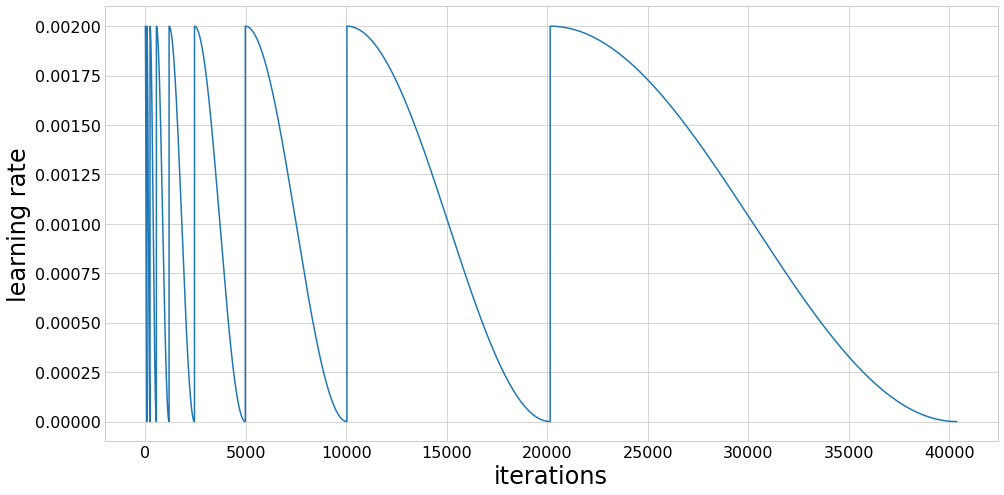

Fold took 516.122s

Training model 9 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.367305). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.184056). Check your callbacks.
  % delta_t_median)


1 New best found: 3.762955769717501e-05
2 New best found: 3.555506102061456e-05
3 New best found: 3.5024394124438715e-05
4 New best found: 3.473655414541971e-05
5 New best found: 3.411141262662672e-05
6 New best found: 3.371443525136705e-05
7 New best found: 3.353210080571169e-05
11 New best found: 3.334803131930125e-05
12 New best found: 3.319746941350026e-05
13 New best found: 3.2877097106964204e-05
14 New best found: 3.277114699063403e-05
15 New best found: 3.275388628311808e-05
24 New best found: 3.259361879139999e-05
25 New best found: 3.255159999374409e-05
26 New best found: 3.2461999585484825e-05
28 New best found: 3.235977740230401e-05
29 New best found: 3.228139179707985e-05
30 New best found: 3.227980288586947e-05
31 New best found: 3.227424482326846e-05
49 New best found: 3.226653539235722e-05
51 New best found: 3.219439248727617e-05
53 New best found: 3.2128593324702915e-05
55 New best found: 3.2012594976113703e-05
56 New best found: 3.197612688833601e-05
58 New best found:

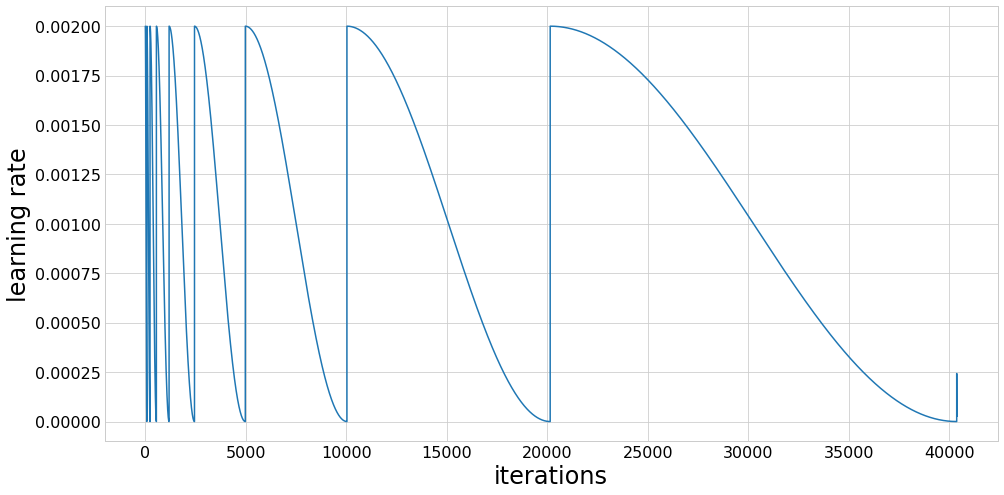

Fold took 527.020s

Training model 10 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.412569). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206688). Check your callbacks.
  % delta_t_median)


1 New best found: 3.723084042640218e-05
2 New best found: 3.576094451787787e-05
3 New best found: 3.462296511914421e-05
4 New best found: 3.457114041373493e-05
5 New best found: 3.397994630509465e-05
6 New best found: 3.353474379739201e-05
7 New best found: 3.319525123700927e-05
11 New best found: 3.289167861238706e-05
13 New best found: 3.2682982212138435e-05
14 New best found: 3.252763543471647e-05
15 New best found: 3.251899183941826e-05
22 New best found: 3.2337649114440596e-05
23 New best found: 3.232915120311973e-05
24 New best found: 3.218453167368848e-05
25 New best found: 3.216994923912362e-05
26 New best found: 3.2150274448284474e-05
28 New best found: 3.209802978083615e-05
29 New best found: 3.203568043925626e-05
30 New best found: 3.20137395775145e-05
31 New best found: 3.200950977324518e-05
47 New best found: 3.1986942716697404e-05
50 New best found: 3.189453649230487e-05
52 New best found: 3.186628494119829e-05
55 New best found: 3.186533902091714e-05
56 New best found: 3

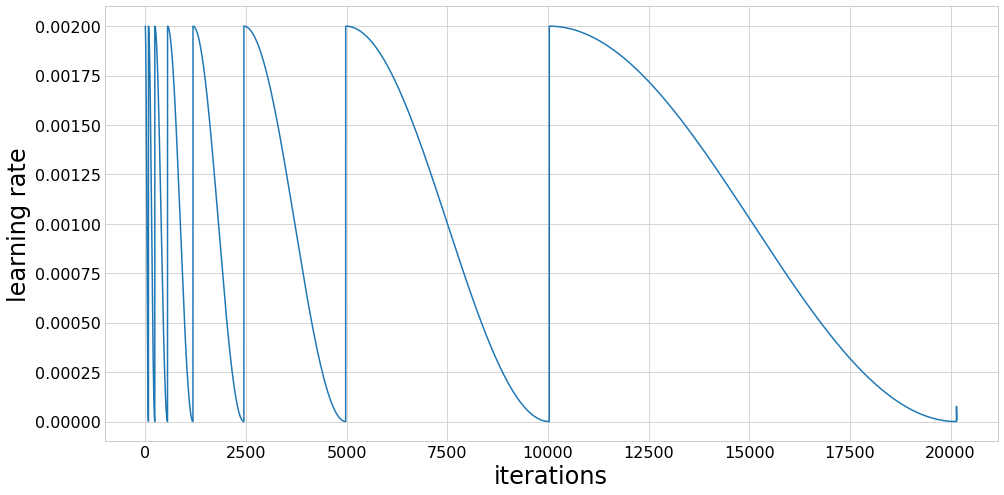

Fold took 277.851s


______________________________________
Training finished
Cross-validation took 3739.534s 


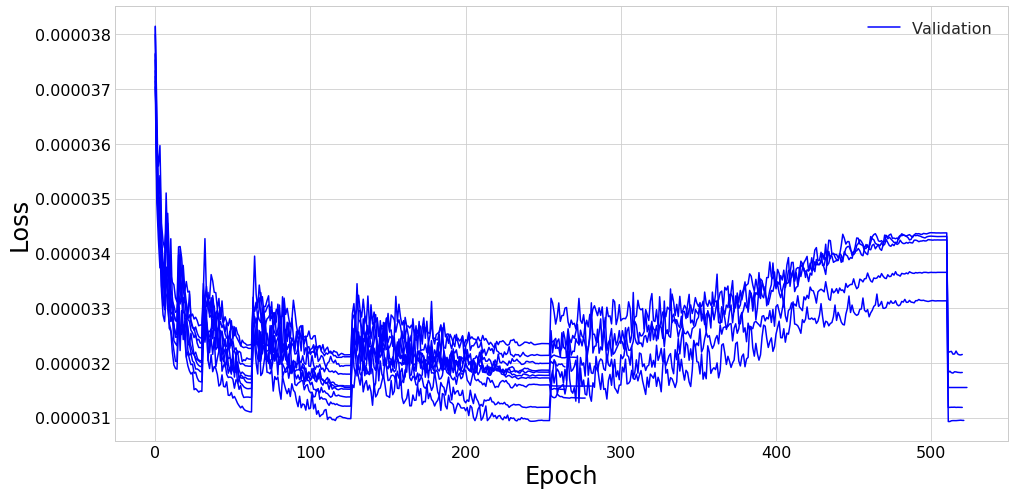

Mean loss = 3.16e-05 +- 1e-07
Mean wAUC = 0.0627 +- 0.0005
Mean AUC = 0.0976 +- 0.0004
Mean AMS = 3.88 +- 0.05
Mean cut = 0.957 +- 0.005
______________________________________



<Figure size 432x288 with 0 Axes>

In [9]:
results, histories = fold_train_model(train_fy, n_models,
                                      model_gen_params=model_gen_params,
                                      train_params=train_params, train_on_weights=True,
                                      use_callbacks=use_callbacks, ams_args=ams_args,
                                      max_epochs=max_epochs, patience=patience,
                                      verbose=1, plots=plots)

## Construct ensemble

In [10]:
with open('train_weights/resultsFile.pkl', 'rb') as fin:   
    results = pickle.load(fin)

In [11]:
ensemble, weights = assemble_ensemble(results, ensemble_size, ensemble_mode, compile_args)

Choosing ensemble by loss
Model 0 is 6 with loss = 3.092931936179059e-05
Model 1 is 0 with loss = 3.118378692452097e-05
Model 2 is 2 with loss = 3.135644969547475e-05
Model 3 is 9 with loss = 3.151038108046013e-05
Model 4 is 7 with loss = 3.1550753943884044e-05
Model 5 is 3 with loss = 3.157670626058918e-05
Model 6 is 8 with loss = 3.1769982307785616e-05
Model 7 is 5 with loss = 3.1919100441155024e-05
Model 8 is 4 with loss = 3.2093151984736326e-05
Model 9 is 1 with loss = 3.210141609089351e-05


## Response on validation data without TTA

In [12]:
val_fy = FoldYielder(h5py.File(DATA_PATH/'val.hdf5', "r+"))

In [13]:
fold_ensemble_predict(ensemble, weights, val_fy, ensemble_size=ensemble_size, verbose=1)

Predicting fold 1 out of 10
Prediction took 0.00178447494097054s per sample

Predicting fold 2 out of 10
Prediction took 0.0003902396459132433s per sample

Predicting fold 3 out of 10
Prediction took 0.00038919663839042187s per sample

Predicting fold 4 out of 10
Prediction took 0.00038723395653069017s per sample

Predicting fold 5 out of 10
Prediction took 0.0003959773078560829s per sample

Predicting fold 6 out of 10
Prediction took 0.0003994222994893789s per sample

Predicting fold 7 out of 10
Prediction took 0.0004001996502280235s per sample

Predicting fold 8 out of 10
Prediction took 0.00039265646636486054s per sample

Predicting fold 9 out of 10
Prediction took 0.00039692380838096143s per sample

Predicting fold 10 out of 10
Prediction took 0.00038894996903836727s per sample



In [14]:
val_df = convert_to_df(val_fy.source)

50000 candidates loaded


In [15]:
print('Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(val_df.gen_target, val_df.pred_class),
                                                           roc_auc_score(val_df.gen_target, val_df.pred_class, sample_weight=val_df.gen_weight)))

Testing ROC AUC: unweighted 0.9044031290740384, weighted 0.9365054694730353


Best cut at 0.9667505741835356 corresponds to AMS of 3.9783566799336363
Maximum AMS for data is 4.004253922902579 at cut of 0.966160774230957
CPU times: user 26.4 s, sys: 382 µs, total: 26.4 s
Wall time: 26.5 s


/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


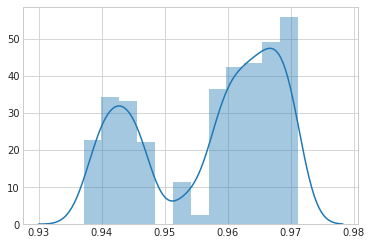

In [16]:
%%time
cut_kde = kde_optimise_cut(val_df, top_perc=0.05, br=10, w_factor=250000/50000)

Mean cut at 0.95726365 corresponds to AMS of 3.776394961755734
Maximum AMS for data is 4.004253922902579 at cut of 0.966160774230957
CPU times: user 88.3 ms, sys: 41.4 ms, total: 130 ms
Wall time: 80.5 ms


/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


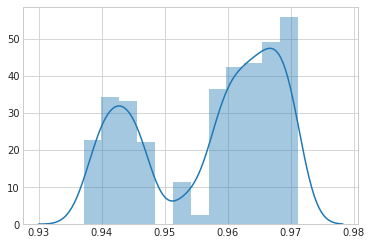

In [17]:
%%time
cut_mean = mean_optimise_cut(val_df, top_perc=0.05, br=10, w_factor=250000/50000)

## Response on validation data with TTA

In [18]:
val_fy = HEPAugFoldYielder(train_feats, h5py.File(DATA_PATH/'val.hdf5', "r+"), rotate=False,
                             input_pipe=None, rot_mult=8)

Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 4


In [19]:
fold_ensemble_predict(ensemble, weights, val_fy, pred_name='pred_TTA', ensemble_size=ensemble_size, verbose=1)

Predicting fold 1 out of 10
Prediction took 0.001620298681780696s per sample

Predicting fold 2 out of 10
Prediction took 0.0015916624322533607s per sample

Predicting fold 3 out of 10
Prediction took 0.0015819695010781288s per sample

Predicting fold 4 out of 10
Prediction took 0.0015955816734582187s per sample

Predicting fold 5 out of 10
Prediction took 0.0015822372127324343s per sample

Predicting fold 6 out of 10
Prediction took 0.001595716730132699s per sample

Predicting fold 7 out of 10
Prediction took 0.0015977294415235519s per sample

Predicting fold 8 out of 10
Prediction took 0.0015803832534700632s per sample

Predicting fold 9 out of 10
Prediction took 0.001600302418321371s per sample

Predicting fold 10 out of 10
Prediction took 0.0015902242071926594s per sample



In [20]:
val_df_tta = convert_to_df(val_fy.source, pred_name='pred_TTA')

50000 candidates loaded


In [21]:
print('Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(val_df_tta.gen_target, val_df_tta.pred_class),
                                                           roc_auc_score(val_df_tta.gen_target, val_df_tta.pred_class, sample_weight=val_df_tta.gen_weight)))

Testing ROC AUC: unweighted 0.9044731744190104, weighted 0.9365460474094318


Best cut at 0.9669439846330935 corresponds to AMS of 3.9572695893159673
Maximum AMS for data is 4.001496747845173 at cut of 0.9658512473106384
CPU times: user 26.5 s, sys: 5.28 ms, total: 26.5 s
Wall time: 26.5 s


/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


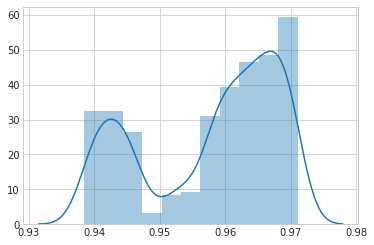

In [22]:
%%time
cut_kde_tta = kde_optimise_cut(val_df_tta, top_perc=0.05, br=10, w_factor=250000/50000)

Mean cut at 0.957879 corresponds to AMS of 3.8025579196151
Maximum AMS for data is 4.001496747845173 at cut of 0.9658512473106384
CPU times: user 85.7 ms, sys: 41.4 ms, total: 127 ms
Wall time: 78 ms


/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


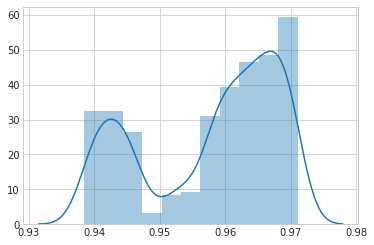

In [23]:
%%time
cut_mean_tta = mean_optimise_cut(val_df_tta, top_perc=0.05, br=10, w_factor=250000/50000)

# Test scoring - Without TTA

In [24]:
test_fy = FoldYielder(h5py.File(DATA_PATH/'testing.hdf5', "r+"))

In [25]:
%%time
fold_ensemble_predict(ensemble, weights, test_fy, ensemble_size=ensemble_size, verbose=1)

Predicting fold 1 out of 10
Prediction took 0.0003876400548964739s per sample

Predicting fold 2 out of 10
Prediction took 0.00038711916066028857s per sample

Predicting fold 3 out of 10
Prediction took 0.00038652079897848044s per sample

Predicting fold 4 out of 10
Prediction took 0.0003884642082181844s per sample

Predicting fold 5 out of 10
Prediction took 0.0003869231991131197s per sample

Predicting fold 6 out of 10
Prediction took 0.000390317666632208s per sample

Predicting fold 7 out of 10
Prediction took 0.0003869214142926715s per sample

Predicting fold 8 out of 10
Prediction took 0.000392397634989836s per sample

Predicting fold 9 out of 10
Prediction took 0.0003923073341900652s per sample

Predicting fold 10 out of 10
Prediction took 0.00039599127434194087s per sample

CPU times: user 3min 54s, sys: 6.09 s, total: 4min
Wall time: 3min 34s


In [26]:
score_test_data(test_fy.source, cut_kde)

Public:Private AMS: 3.5591071292899037 : 3.718195529440757


(3.5591071292899037, 3.718195529440757)

In [27]:
score_test_data(test_fy.source, cut_mean)

Public:Private AMS: 3.7415073724941066 : 3.798125978348075


(3.7415073724941066, 3.798125978348075)

# Test scoring - With TTA

In [28]:
test_fy = HEPAugFoldYielder(train_feats, h5py.File(DATA_PATH/'testing.hdf5', "r+"), rotate=False,
                             input_pipe=None, rot_mult=8)

Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 4


In [29]:
%%time
fold_ensemble_predict(ensemble, weights, test_fy, pred_name='pred_TTA', ensemble_size=ensemble_size, verbose=1)

Predicting fold 1 out of 10
Prediction took 0.0015625455974855207s per sample

Predicting fold 2 out of 10
Prediction took 0.0015550844140350818s per sample

Predicting fold 3 out of 10
Prediction took 0.0015639768647199327s per sample

Predicting fold 4 out of 10
Prediction took 0.0015636769646948034s per sample

Predicting fold 5 out of 10
Prediction took 0.001567774038118395s per sample

Predicting fold 6 out of 10
Prediction took 0.001570887798612768s per sample

Predicting fold 7 out of 10
Prediction took 0.0015463911812752485s per sample

Predicting fold 8 out of 10
Prediction took 0.0015513148158450018s per sample

Predicting fold 9 out of 10
Prediction took 0.0015472034253857354s per sample

Predicting fold 10 out of 10
Prediction took 0.0015493429907682268s per sample

CPU times: user 15min 37s, sys: 23.2 s, total: 16min
Wall time: 14min 16s


In [30]:
score_test_data(test_fy.source, cut_kde_tta, pred_name='pred_TTA')

Public:Private AMS: 3.623400575374949 : 3.7241337018624394


(3.623400575374949, 3.7241337018624394)

In [31]:
score_test_data(test_fy.source, cut_mean_tta, pred_name='pred_TTA')

Public:Private AMS: 3.7597334992553257 : 3.7802629798207503


(3.7597334992553257, 3.7802629798207503)

# Save/Load

In [ ]:
name = "weights/Swish_CLR_TTA"

In [ ]:
saveEnsemble(name, ensemble, weights, compile_args, overwrite=1)

In [ ]:
ensemble, weights, compile_args, _, _ = loadEnsemble(name)